In [15]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


# Define the model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mse')

# Define the directories
lr_folder = 'lrimg'
hr_folder = 'hr_image'

# Load and preprocess the dataset
X = []
y = []

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))  # Specify desired dimensions
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to the range [0, 1]
    return img_array

for image_file in os.listdir(lr_folder):
    # Load and preprocess the low-resolution image
    lr_img_array = load_and_preprocess_image(os.path.join(lr_folder, image_file))
    
    # Load and preprocess the corresponding high-resolution image
    hr_img_array = load_and_preprocess_image(os.path.join(hr_folder, image_file))
    
    X.append(lr_img_array)
    y.append(hr_img_array)

X = np.array(X)
y = np.array(y)

# Print shapes for debugging
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Split the dataset manually
val_index = int(0.8 * len(X))  # Use 80% for training, 20% for validation

# Print validation index for debugging
print("Validation Index:", val_index)

X_train, X_val = X[:val_index], X[val_index:]
y_train, y_val = y[:val_index], y[val_index:]

# Print shapes after splitting for debugging
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

# Define callbacks, including model checkpoint to save the best model during training
checkpoint = ModelCheckpoint('super_resolution_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16, callbacks=[checkpoint])

# Optionally, you can save the final trained model
model.save('final_super_resolution_model.h5')


[]
Shape of X: (600, 256, 256, 3)
Shape of y: (600, 256, 256, 3)
Validation Index: 480
Shape of X_train: (480, 256, 256, 3)
Shape of y_train: (480, 256, 256, 3)
Shape of X_val: (120, 256, 256, 3)
Shape of y_val: (120, 256, 256, 3)
Epoch 1/10
30/30 [==============================] - 150s 5s/step - loss: 0.0361 - val_loss: 0.0044
Epoch 2/10
30/30 [==============================] - 150s 5s/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/10
30/30 [==============================] - 150s 5s/step - loss: 7.3885e-04 - val_loss: 6.2819e-04
Epoch 4/10
30/30 [==============================] - 150s 5s/step - loss: 5.4163e-04 - val_loss: 4.5294e-04
Epoch 5/10
30/30 [==============================] - 150s 5s/step - loss: 3.7245e-04 - val_loss: 3.3947e-04
Epoch 6/10
30/30 [==============================] - 151s 5s/step - loss: 2.8349e-04 - val_loss: 2.5552e-04
Epoch 7/10
30/30 [==============================] - 151s 5s/step - loss: 2.1398e-04 - val_loss: 2.0473e-04
Epoch 8/10
30/30 [==================

19/19 [==============================] - 44s 2s/step
Accuracy: 0.9973467000325521
Precision: 0.9865181558623383
Recall: 0.9587272947743627
F1 Score: 0.9724242074501405


<Figure size 800x600 with 0 Axes>

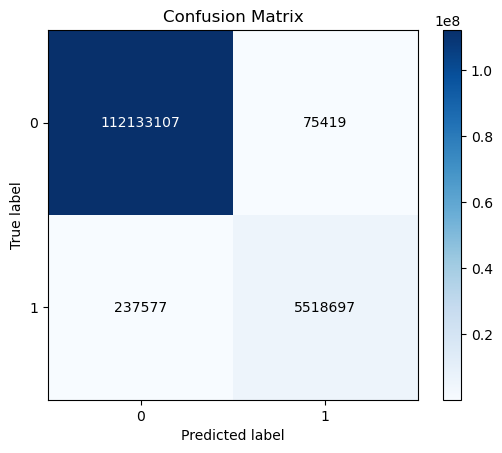

AttributeError: 'Axes' object has no attribute 'ax_'

<Figure size 800x600 with 0 Axes>

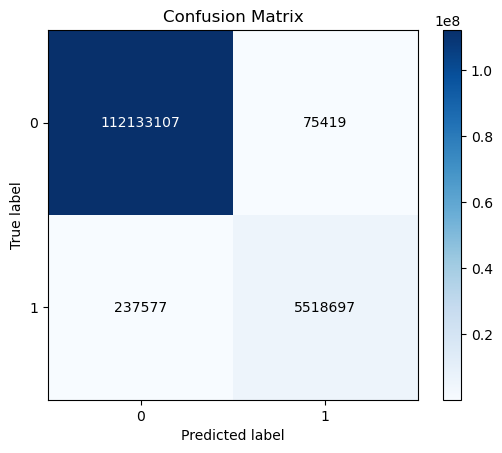

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import scikitplot as skplt


# Define the load_and_preprocess_test_data function
def load_and_preprocess_test_data():
    
    lr_image_paths = [os.path.join(  'lrimg', filename) for filename in os.listdir(os.path.join('lrimg'))]
    hr_image_paths = [os.path.join(  'hr_image', filename) for filename in os.listdir(os.path.join('hr_image'))]
    X_test_lr = np.array([load_and_preprocess_image(image_path) for image_path in lr_image_paths])
    y_test_hr = np.array([load_and_preprocess_image(image_path) for image_path in hr_image_paths])
    
    return X_test_lr, y_test_hr

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))  # Specify desired dimensions
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to the range [0, 1]
    return img_array

# Load test data and model
X_test, y_test = load_and_preprocess_test_data()
trained_model = load_model('final_super_resolution_model.h5')

# Make predictions on the test data
y_pred = trained_model.predict(X_test)

# Flatten and discretize the arrays for classification
y_test_flat = np.round(y_test).astype(int).reshape(-1)
y_pred_flat = np.round(y_pred).astype(int).reshape(-1)

# Use label encoding for unique classes
label_encoder = LabelEncoder()
label_encoder.fit(np.unique(np.concatenate((y_test_flat, y_pred_flat))))
y_test_encoded = label_encoder.transform(y_test_flat)
y_pred_encoded = label_encoder.transform(y_pred_flat)

# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
precision = precision_score(y_test_encoded, y_pred_encoded)
recall = recall_score(y_test_encoded, y_pred_encoded)
f1 = f1_score(y_test_encoded, y_pred_encoded)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
skplt.metrics.plot_confusion_matrix(y_test_encoded, y_pred_encoded, cmap=plt.cm.Blues, text_fontsize='medium')
plt.title('Confusion Matrix')
plt.show()

# Display TP, TN, FP, FN values on the plot
plt.figure(figsize=(8, 6))
disp = skplt.metrics.plot_confusion_matrix(y_test_encoded, y_pred_encoded, cmap=plt.cm.Blues, text_fontsize='medium')
disp.ax_.text(0, 0, f'TN = {conf_matrix[0, 0]}', va='center', ha='center', fontsize=12, color='black')
disp.ax_.text(1, 0, f'FP = {conf_matrix[0, 1]}', va='center', ha='center', fontsize=12, color='black')
disp.ax_.text(0, 1, f'FN = {conf_matrix[1, 0]}', va='center', ha='center', fontsize=12, color='black')
disp.ax_.text(1, 1, f'TP = {conf_matrix[1, 1]}', va='center', ha='center', fontsize=12, color='black')
plt.title('Confusion Matrix with TP, TN, FP, FN')
plt.show()


In [21]:
!pip install scikit-plot
